
# Predicción del **Rendimiento (t/h)** con **Random Forest** y **XGBoost**
A partir de un CSV BD_Molienda



## Requisitos
```bash
pip install pandas scikit-learn xgboost matplotlib joblib
```


In [ ]:

# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

os.makedirs("salidas_modelo", exist_ok=True)
print("Carpeta 'salidas_modelo' lista.")


Carpeta 'salidas_modelo' lista.



## 1) Carga de datos



In [ ]:

csv_path = "BD_Molienda.csv"
df = pd.read_csv(csv_path, sep=";")
print("Filas x columnas:", df.shape)
df.head()


Filas x columnas: (112, 10)


,Registro,"Velocidad SAG, rpm",%sólidos,"Flujo de agua, m3/h","Horas operadas, h","Rendimiento, t/h","Potencia, kW","Peso Molino, ton","Consumo Energía, kWh","Consumo Específico Energía, kWh/t"
0,1,11.3,73.4,459.2,739.4,1268,4614,463,5116787,5.46
1,2,11.1,71.0,506.6,657.9,1241,4895,626,4830695,5.92
2,3,11.1,72.2,481.1,736.5,1247,5163,631,5703594,6.21
3,4,11.2,73.1,457.8,666.7,1243,5748,736,5748645,6.94
4,5,11.5,74.0,440.9,729.4,1257,4570,638,4999876,5.45



## 2) Selección de variables y objetivo
- `Flujo de agua, m3/h` → `Flujo_agua_m3h`
- `Velocidad SAG, rpm` → `Velocidad_SAG_rpm`
- Objetivo: `Rendimiento, t/h`


In [ ]:

feature_map = {
    "Flujo de agua, m3/h": "Flujo_agua_m3h",
    "Velocidad SAG, rpm": "Velocidad_SAG_rpm",
}
target_col = "Rendimiento, t/h"

X = df[list(feature_map.keys())].rename(columns=feature_map).copy()
y = df[target_col].astype(float)

X.describe(), y.describe()


(       Flujo_agua_m3h  Velocidad_SAG_rpm
 count      112.000000         112.000000
 mean       546.408036          10.702679
 std         99.861255           0.600519
 min        394.900000           9.100000
 25%        472.600000          10.300000
 50%        526.250000          10.800000
 75%        605.500000          11.100000
 max        924.600000          11.600000,
 count     112.000000
 mean     1190.125000
 std        57.173062
 min      1012.000000
 25%      1173.250000
 50%      1207.500000
 75%      1230.000000
 max      1268.000000
 Name: Rendimiento, t/h, dtype: float64)


## 3) Partición entrenamiento / prueba


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((89, 2), (23, 2), (89,), (23,))


## 4) Entrenamiento: Random Forest


In [ ]:
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred)
print(f"Random Forest -> R²: {rf_r2:.4f} | RMSE: {rf_rmse:.4f}")

Random Forest -> R²: 0.8295 | RMSE: 572.9437



## 5) Entrenamiento: XGBoost


In [ ]:
xgb_available = True
xgb_r2 = np.nan
xgb_rmse = np.nan
xgb_pred = None
xgb_feature_importances_ = None

try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        n_estimators=600,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_r2 = r2_score(y_test, xgb_pred)
    xgb_rmse = mean_squared_error(y_test, xgb_pred)
    xgb_feature_importances_ = getattr(xgb, "feature_importances_", None)
    print(f"XGBoost       -> R²: {xgb_r2:.4f} | RMSE: {xgb_rmse:.4f}")
except Exception as e:
    xgb_available = False
    print("XGBoost no disponible:", str(e))

XGBoost       -> R²: 0.6400 | RMSE: 1209.5529



## 6) Métricas comparadas


In [ ]:

metrics = pd.DataFrame({
    "Modelo": ["RandomForest", "XGBoost" if xgb_available else "XGBoost (no disponible)"],
    "R2": [rf_r2, xgb_r2],
    "RMSE": [rf_rmse, xgb_rmse]
})
metrics


,Modelo,R2,RMSE
0,RandomForest,0.829456,572.943665
1,XGBoost,0.639961,1209.552914



## 7) Importancia de variables


In [ ]:

importancias = pd.DataFrame({
    "Feature": X.columns,
    "RF_Importance": rf.feature_importances_,
    "XGB_Importance": xgb_feature_importances_ if xgb_available else [np.nan]*X.shape[1]
}).sort_values("RF_Importance", ascending=False)
importancias


,Feature,RF_Importance,XGB_Importance
0,Flujo_agua_m3h,0.788625,0.642825
1,Velocidad_SAG_rpm,0.211375,0.357175



## 8) Gráficos: Real vs Predicho


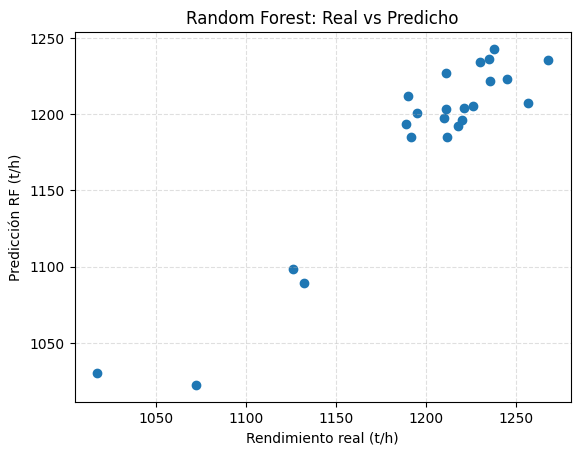

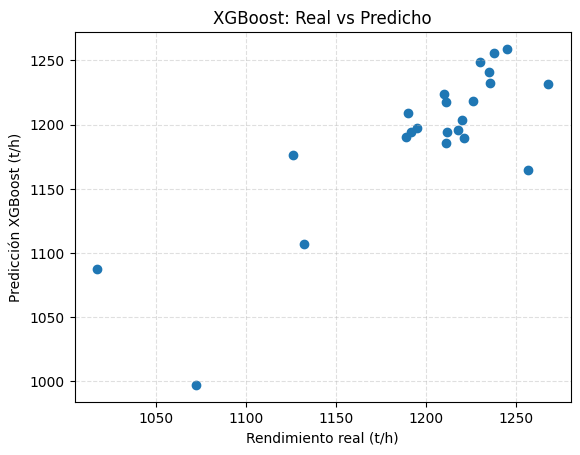

In [ ]:

# Random Forest
plt.figure()
plt.scatter(y_test, rf_pred)
plt.xlabel("Rendimiento real (t/h)")
plt.ylabel("Predicción RF (t/h)")
plt.title("Random Forest: Real vs Predicho")
plt.grid(True, linestyle="--", alpha=0.4)
plt.savefig("salidas_modelo/rf_real_vs_pred.png", bbox_inches="tight")
plt.show()

# XGBoost
if xgb_available:
    plt.figure()
    plt.scatter(y_test, xgb_pred)
    plt.xlabel("Rendimiento real (t/h)")
    plt.ylabel("Predicción XGBoost (t/h)")
    plt.title("XGBoost: Real vs Predicho")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.savefig("salidas_modelo/xgb_real_vs_pred.png", bbox_inches="tight")
    plt.show()



## 9) Guardar modelos


In [ ]:

joblib.dump(rf, "salidas_modelo/modelo_random_forest.pkl")
if xgb_available:
    joblib.dump(xgb, "salidas_modelo/modelo_xgboost.pkl")
print("Modelos guardados en 'salidas_modelo/'.")


Modelos guardados en 'salidas_modelo/'.



## 10) Ejemplo de inferencia


In [ ]:

ejemplo = pd.DataFrame({
    "Flujo_agua_m3h": [440],        # <--- reemplaza con tus valores
    "Velocidad_SAG_rpm": [9.0]
})
pred_rf = rf.predict(ejemplo)[0]
print(f"Predicción RF -> {pred_rf:.2f} t/h")
if xgb_available:
    pred_xgb = xgb.predict(ejemplo)[0]
    print(f"Predicción XGB -> {pred_xgb:.2f} t/h")


Predicción RF -> 1221.59 t/h
Predicción XGB -> 1221.36 t/h
